In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import numpy as np
from PIL import Image
import cv2
import matplotlib.image as mpimg
import os
import scipy.ndimage as ndimage

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2273 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
class_names

['guava_diseased',
 'guava_healthy',
 'jamun_diseased',
 'jamun_healthy',
 'lemon_diseased',
 'lemon_healthy',
 'mango_diseased',
 'mango_healthy',
 'pomegranate_diseased',
 'pomegrenate_healthy']

In [5]:
# for image_batch, labels_batch in dataset.take(1):
#     #print(image_batch.shape)
#     #print(labels_batch.numpy())
    
#     for i in range(12):
#         ax = plt.subplot(3,4,i+1)
        
#         #plt.imshow(image_batch[i].numpy().astype("uint8"))
        
#         def rgb2gray(rgb):
#             return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
        
        
#         img_gray = rgb2gray(image_batch[i])
        
#         def apply_gaussian_blur(img_gray):
#             blurred_image = tf.image.gaussian_filter2d(image, sigma=1.0)
#             return blurred_image
        
#         plt.imshow(img_gray, cmap=plt.get_cmap('gray'))
#         #plt.show()
        
#         plt.title(class_names[labels_batch[i]])
#         plt.axis("off")

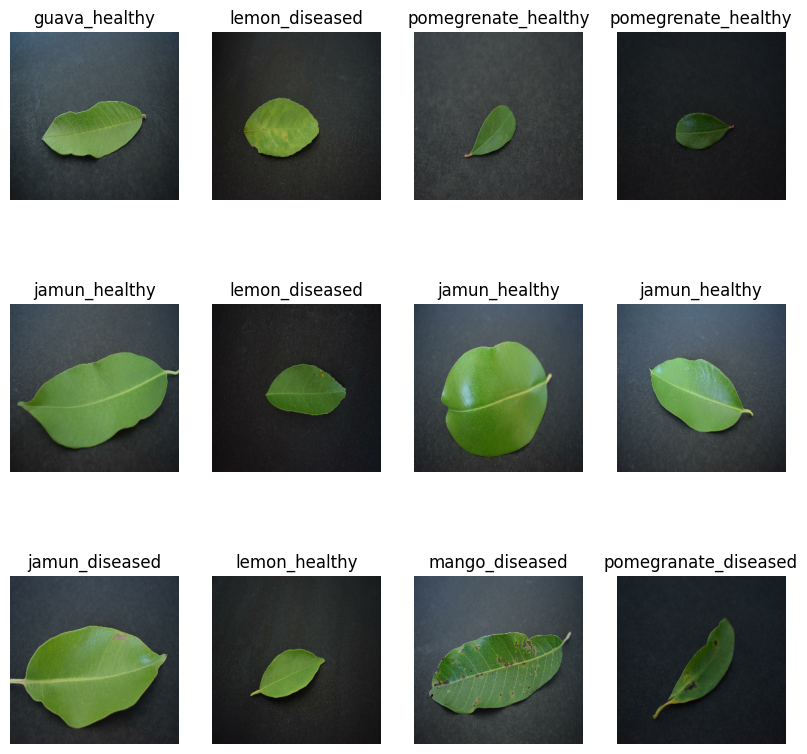

In [6]:
#Display Images

# plt.figure(figsize=(10, 10))
# for image_batch, labels_batch in dataset.take(1):
#     for i in range(12):
#         ax = plt.subplot(3, 4, i + 1)
#         plt.imshow(image_batch[i].numpy().astype("uint8"))
#         plt.title(class_names[labels_batch[i]])
#         plt.axis("off")

In [8]:
len(dataset)

72

In [9]:
train_size = 0.8
len(dataset)*train_size

57.6

In [10]:
train_ds = dataset.take(57)
len(train_ds)

57

In [11]:
test_ds = dataset.skip(57)
len(test_ds)

15

In [12]:
val_size=0.1
len(dataset)*val_size

7.2

In [13]:
val_ds = test_ds.take(7)
len(val_ds)

7

In [14]:
test_ds = test_ds.skip(7)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

57

In [18]:
len(val_ds)

7

In [19]:
len(test_ds)

8

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

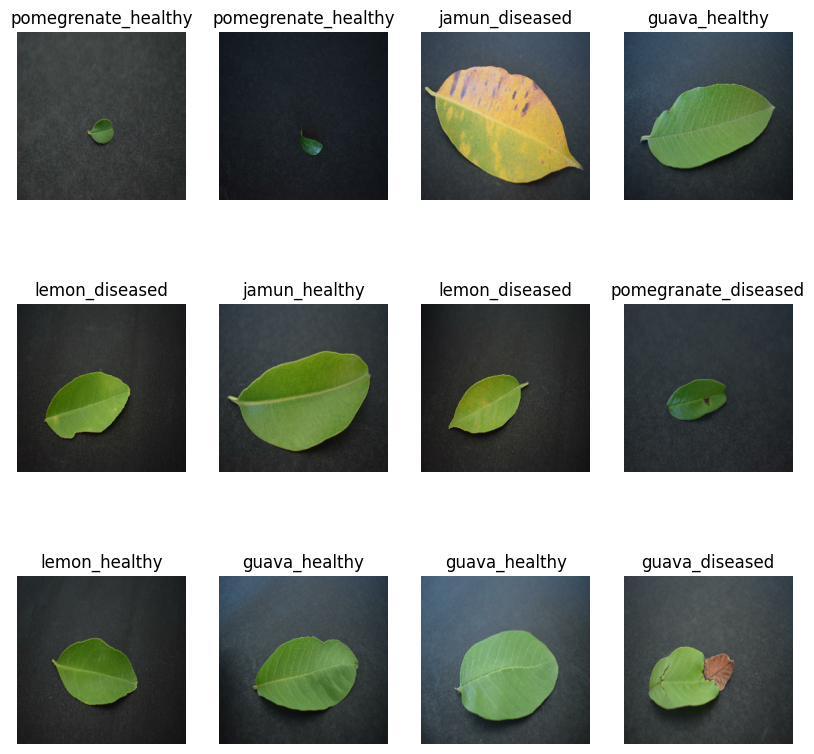

In [58]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

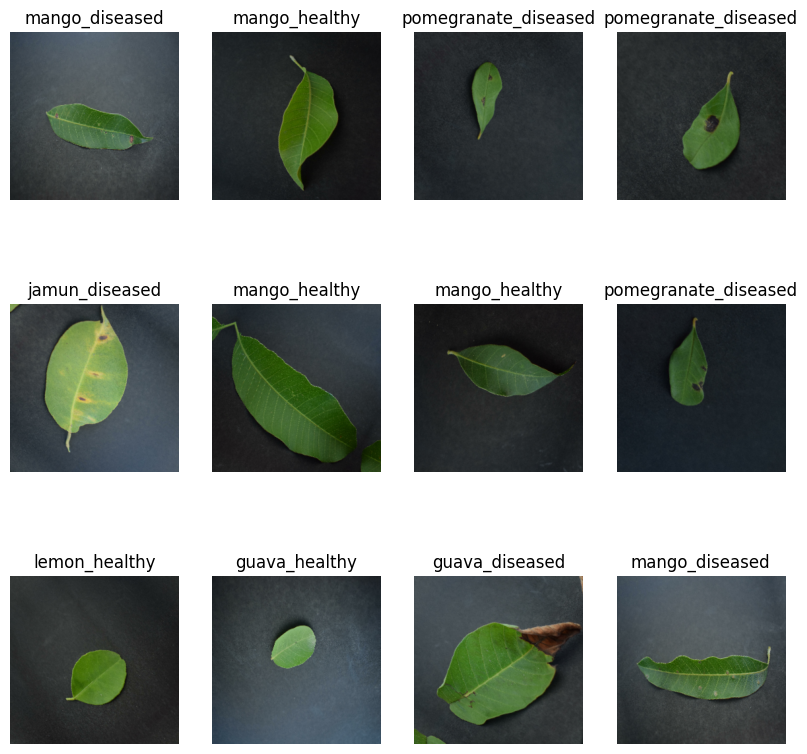

In [60]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [24]:
len(dataset)

72

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (32, 123008)             

In [27]:
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
57/57 [==============================] - 478s 5s/step - loss: 1.9869 - accuracy: 0.2615 - val_loss: 1.4806 - val_accuracy: 0.4643
Epoch 2/30
57/57 [==============================] - 141s 2s/step - loss: 1.2248 - accuracy: 0.5362 - val_loss: 0.9796 - val_accuracy: 0.6562
Epoch 3/30
57/57 [==============================] - 140s 2s/step - loss: 0.9782 - accuracy: 0.6332 - val_loss: 0.6848 - val_accuracy: 0.7321
Epoch 4/30
57/57 [==============================] - 140s 2s/step - loss: 0.8187 - accuracy: 0.7034 - val_loss: 0.6979 - val_accuracy: 0.7455
Epoch 5/30
57/57 [==============================] - 142s 2s/step - loss: 0.7109 - accuracy: 0.7434 - val_loss: 0.5488 - val_accuracy: 0.7946
Epoch 6/30
57/57 [==============================] - 139s 2s/step - loss: 0.6608 - accuracy: 0.7599 - val_loss: 0.5558 - val_accuracy: 0.7768
Epoch 7/30
57/57 [==============================] - 130s 2s/step - loss: 0.6492 - accuracy: 0.7615 - val_loss: 0.4733 - val_accuracy: 0.8259
Epoch 8/30
57

In [29]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 103s 402ms/step - loss: 0.3509 - accuracy: 0.8672


In [30]:
scores2 = model.evaluate(train_ds)

57/57 [==============================] - 33s 579ms/step - loss: 0.2810 - accuracy: 0.8980


In [31]:
scores3 = model.evaluate(val_ds)

7/7 [==============================] - 3s 408ms/step - loss: 0.3994 - accuracy: 0.8571


In [32]:
scores

[0.3508935868740082, 0.8671875]

In [33]:
scores2

[0.28102749586105347, 0.8980262875556946]

In [34]:
scores3

[0.39941930770874023, 0.8571428656578064]

In [35]:
history

In [36]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 57}

In [37]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [38]:
type(history.history['loss'])

list

In [39]:
len(history.history['loss'])

30

In [40]:
history.history['loss'][:5]

[1.986860990524292,
 1.2248384952545166,
 0.978175699710846,
 0.8186606764793396,
 0.7108526825904846]

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

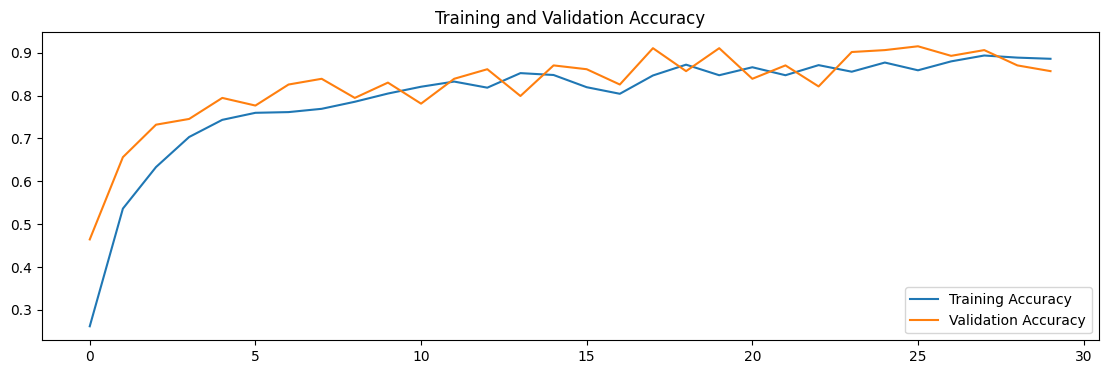

In [45]:
plt.figure(figsize=(30, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

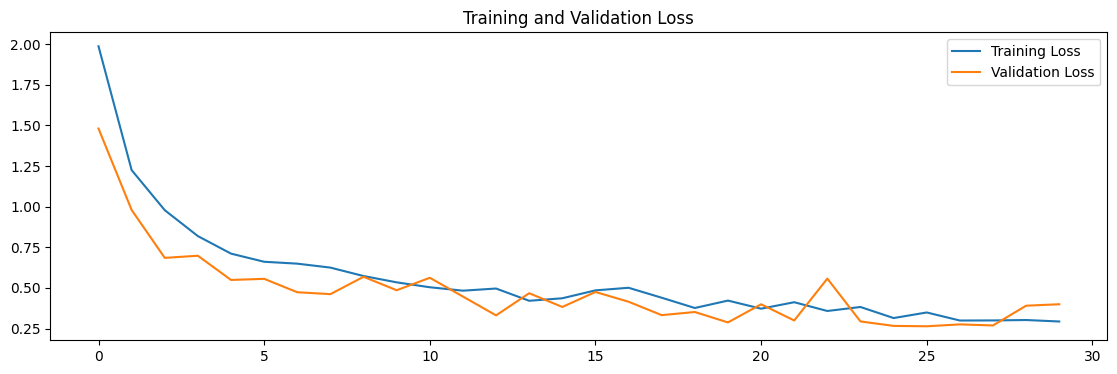

In [43]:
plt.figure(figsize=(30, 4))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: guava_healthy
1/1 [==============================] - 1s 689ms/step
predicted label: guava_healthy


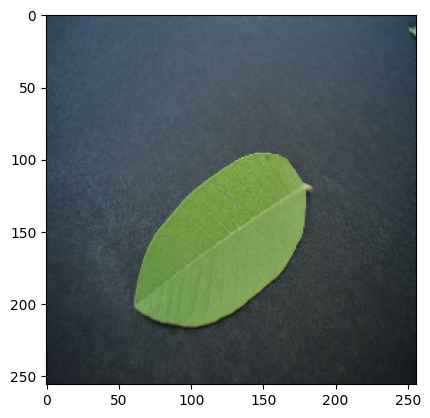

In [57]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [64]:
#Test - Accuracy curve for particular class


# class_index = 5  # Index of the desired class
# class_accuracy = history.history['accuracy'][class_index]



# epochs = EPOCHS

# plt.plot(epochs, class_accuracy, label='Class Accuracy')
# plt.title('Accuracy Curve - Class {}'.format(class_index))
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [47]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 62ms/step


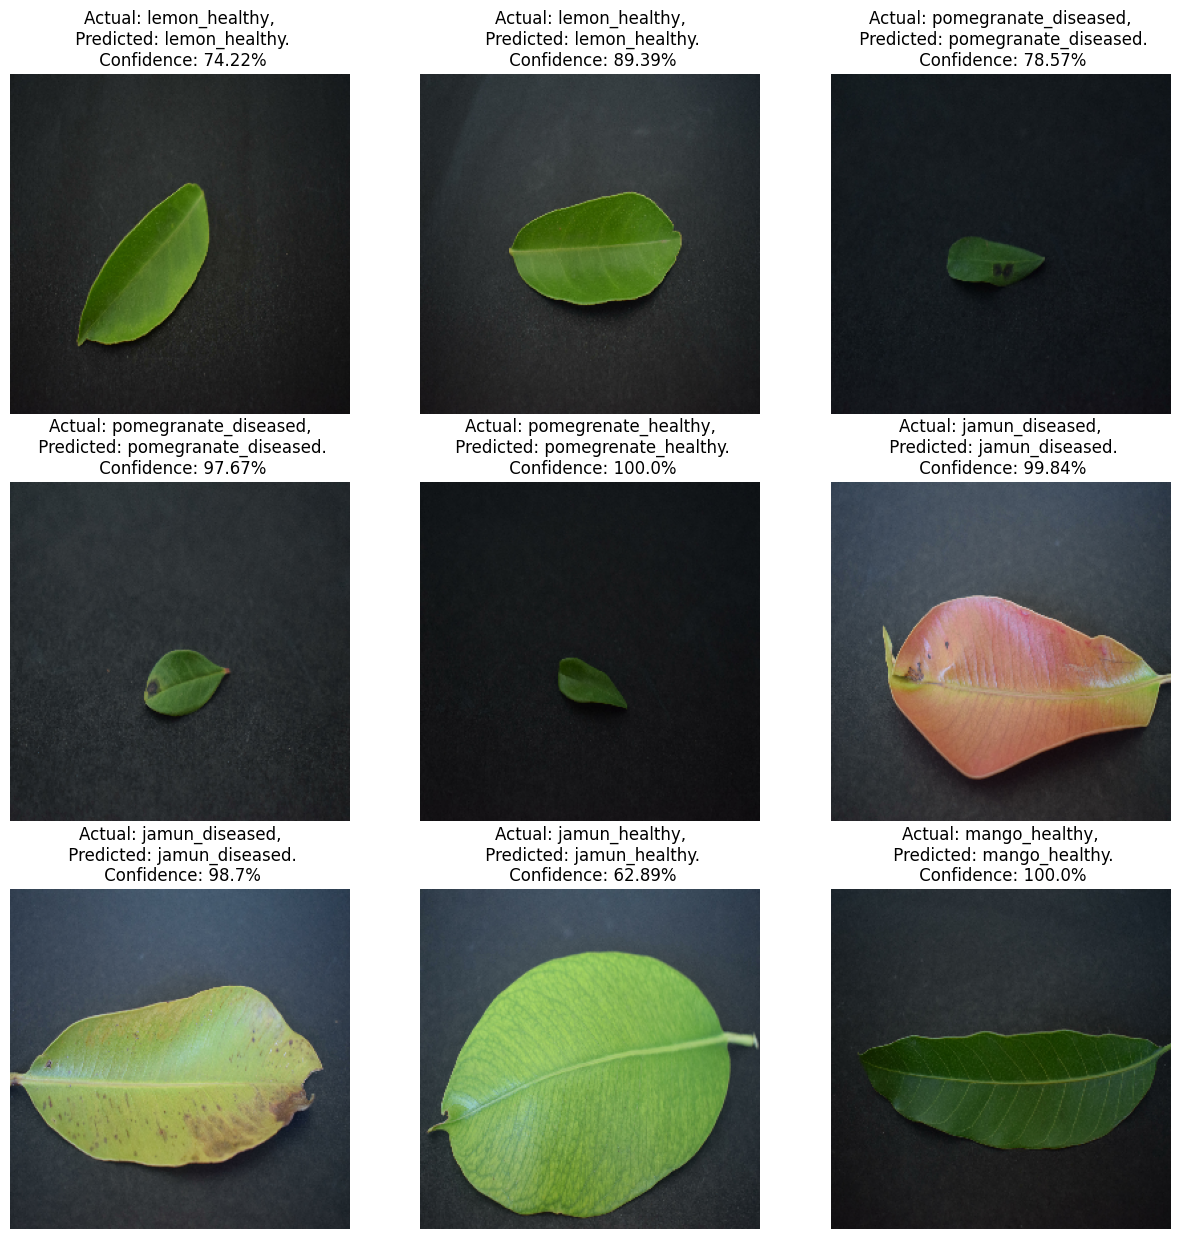

In [56]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")